In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [3]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, measure
from skimage.morphology import dilation, square, binary_opening
from skimage.draw import rectangle_perimeter
import numpy as np
import os.path as path
import scipy.io as sio
import scipy
from scipy import misc
from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
import pickle
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd 
import matplotlib.patheffects as path_effects

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

# sys.path.append('/home/skong2/project/dpff4ldl')
# from utils.metrics import *
# from losses import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
1.13.1+cu116


In [4]:
#### set project name, save directory for the project
project_name = '02_Exp1_SmallGrains'
trials = ['Trial_01', 'Trial_02', 'Trial_03','Trial_04' ]
trial = trials[3] 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # for regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [1040,1392] # set to crop size, to tell model what size tensor to expect
total_epoch_num = 80  # total number of epoch in training
base_lr =0.0005        #0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = '/content/gdrive/MyDrive/exp' # experiment directory, used for reading the init model
exp_dir = os.path.join(exp_dir, project_name)
save_dir = os.path.join(exp_dir, trial) # where to save the log file and trained models.

gen_det_save_dir = '/content/gdrive/MyDrive/exp/01_Generalized_Model_FullTrainingData/Trial_03'

cuda:0


In [5]:
eval_dir = '/content/gdrive/MyDrive/eval' 
eval_dir = os.path.join(eval_dir, project_name, trial) 
if not os.path.exists(eval_dir): 
    os.makedirs(eval_dir)

In [18]:
path_to_image = '/content/gdrive/MyDrive/UTRECHT/Detection/Training_Tiles3'
path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/Masks9_noNPP_circleMask'
path_to_annotCombo = '/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask'
with open(os.path.join(gen_det_save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)    

# with open(os.path.join(save_dir,'dbinfo.plk'), 'rb') as handle:
#     dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 2389, 597)

In [19]:
class PollenDet4Eval(Dataset):
    def __init__(self, path_to_image='/content/gdrive/Othercomputers/My MacBook Air/Training_Tiles3',
                 path_to_annot='/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask',
                 path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/Masks9_noNPP_circleMask',
                 dbinfo=dbinfo,
                 size=[1040,1392], 
                 set_name='test'):
        
        self.path_to_image = path_to_image
        self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx] 

        current_image_path= os.path.join(self.path_to_image, current_example)
        current_distTransform_path=os.path.join(self.path_to_mask, current_example)
        curPickleName = path.join(self.path_to_annot, current_example)

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.bmp'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice))
            image = np.block(imagestack_array)
          if image.shape[2] <27:
            pad_val = 27-image.shape[2]
            npad = ((0, 0), (0,0), (0,pad_val))
            image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        for file in sorted(os.listdir(current_distTransform_path)):
          if file.endswith('.bmp'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.expand_dims(mask, axis=2)

        for file in sorted(os.listdir(curPickleName)):
          if file.endswith('.pkl'):
            with open(os.path.join(curPickleName, file), 'rb') as handle:
              annot = pickle.load(handle)

        times = np.random.randint(1)
        if times!=0:
            if times==1:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[1]-x
                    annot['coord_peaks'][i][1] = y
                    annot['size'] = (annot['size'][1], annot['size'][0])                    
            elif times==2:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[0]-y
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[1]-x
            elif times==3:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = x
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[0]-y
                    annot['size'] = (annot['size'][1], annot['size'][0])
            #for _ in range(times):
            image = np.rot90(image, times).copy()
        

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added       

        image_label = np.concatenate((image, label, mask), axis=2) #12/13/21 added


        mask_distanceTransform = np.copy(mask)     #11/18/21 edited
        
        labelOrgSize = np.copy(mask)
        labelOrgSize = torch.from_numpy(labelOrgSize).unsqueeze(0).unsqueeze(0).squeeze(4)
        labelOrgSize = F.interpolate(labelOrgSize, size=(self.size[0], self.size[1]), mode='nearest') # standardize original label size

        # mask_peaksOrgSize = labelOrgSize*0.    

        # mask_distanceTransformOrgSize  = mask_distanceTransform.copy().astype(np.float32)

        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000

        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)       
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)
        # mask_distanceTransformOrgSize = torch.from_numpy(mask_distanceTransformOrgSize).unsqueeze(0)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)       

        height,width,layer = image_label.shape
        crop0 = image_label[0:800, 0:800,:]
        crop1 = image_label[0:800, width-800:,:]
        crop2 = image_label[height-800:, 0:800,:]
        crop3 = image_label[height-800:, width-800:,:]

        croplist = [crop0, crop1, crop2, crop3]
        imgList=[]
        labelList=[]
        mask_DTList=[]

        for idx2 in range(len(croplist)):
          image_label = croplist[idx2]
          image_label = self.TF2tensor(image_label)
          image_label = image_label.unsqueeze(0)  
          image = torch.narrow(image_label, 1, 0, image_label.shape[1]-2) 
          label=torch.narrow(image_label, 1, image_label.shape[1]-2, 1) 
          mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

          image_label = image_label.squeeze(0)
          image = self.TFNormalize(image)

          imgList.append(image)
          labelList.append(label)
          mask_DTList.append(mask_distanceTransform)

        image = torch.concat(imgList)
        label = torch.concat(labelList)
        mask_distanceTransform = torch.concat(mask_DTList)

        image = image.squeeze(0)
        label = label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        labelOrgSize = labelOrgSize.squeeze(0)

        return image, label, mask_distanceTransform, labelOrgSize, current_example
        # return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius, labelOrgSize, mask_peaksOrgSize, mask_distanceTransformOrgSize, mask_radiusOrgSize

In [20]:
set_name = 'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              path_to_annot=path_to_annotCombo,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=True, 
                         num_workers=4) # num_work can be set to batch_size



# Define functions

In [21]:
def IOU(box1, box2):
    """
We assume that the box follows the format:
box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
where (x1,y1) and (x3,y3) represent the top left coordinate,
and (x2,y2) and (x4,y4) represent the bottom right coordinate
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    
    assert x1 < x2
    assert y1 < y2
    assert x3 < x4
    assert y3 < y4

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    # intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x4 - x3) * (y4 - y3)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [22]:
def nms(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    bbox_list_thresholded.remove(box)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt

In [23]:
# modifying NMS to probabilistic fusion
def probabilistic_fusion(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    norm_fused_score_list = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)

        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    score_1=current_box[1]
                    score_2=box[1]
                    score_1_nonPollen=1-score_1
                    score_2_nonPollen=1-score_2
                    fused_score = score_1*score_2
                    fused_score_nonPollen = score_1_nonPollen*score_2_nonPollen
                    norm_fused_score = fused_score/(fused_score+fused_score_nonPollen)
                    current_box[1] = norm_fused_score
                    bbox_list_thresholded.remove(box)


                    current_box_txt = (current_box[0], str(norm_fused_score) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
                    current_box_txt = ' '.join(current_box_txt)
                    bbox_list_new_txt[-1] = current_box_txt
                    norm_fused_score_list.append(norm_fused_score)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt,norm_fused_score_list

In [24]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

# Small grain detector export
Export text files of ground-truth and prediction bounding boxes for evaluation

In [25]:
################## init model ###################
path_to_save_paramOnly = path.join(exp_dir, trial, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
curmodel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
curmodel.load_state_dict(torch.load(path_to_save_paramOnly)) #, map_location=torch.device('cpu')
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

False


In [26]:
a_list = [0.0, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
beta_list = [-0.5, -0.4, -0.3, -0.2, -0.1, -0.15, 0.0, 0.1, 0.2, 0.3, 0.4]

# to try: (0.1,0.0)
a = a_list[21]
b = beta_list[6]
print(a, b)

2.0 0.0


In [27]:
gen_detections_dir = '/content/gdrive/MyDrive/eval/01_Generalized_Model_FullTrainingData/Trial_03/det'

params = ['02_a_00_b','10_a_00_b','10_a_00_b_noNMS',
          '20_a_00_b','10_a_00_b_prob_fuse',
          '02_a_00_b_prob_fuse','20_a_00_b_prob_fuse',
          '12_a_00_b_prob_fuse', '10_a_00_b_prob_fuse_conf01',
          '10_a_00_b_prob_fuse_conf1_beforeFuse','10_a_00_b_prob_fuse_conf03',
          'sigmoid_fused_nms','sigmoid_fused_nms_10_a_-04_b',
          'sigmoid_fused_nms_07_a_-015_b','sigmoid_fused_nms_07_a_-04_b',
          'sigmoid_prob_fused_07_a_-04_b','sigmoid_fused_nms_07_a_-04_b_v2',
          'sigmoid_fused_nms_conf04_thresh_stepwise','sigmoid_fused_nms_06_a_-04_b',
          'sigmoid_fused_nms_05_a_-04_b','sigmoid_fused_nms_05_a_-015_b',
          'sigmoid_fused_nms_05_a_-05_b','small_grain_only_10a_00b',
          'small_grain_only_20a_00b_sigmoid', 'sigmoid_fused_20a_00b']

detections_dir = os.path.join(eval_dir, params[24],'det')
if not os.path.exists(detections_dir): 
    os.makedirs(detections_dir)
print(detections_dir)

/content/gdrive/MyDrive/eval/02_Exp1_SmallGrains/Trial_04/sigmoid_fused_20a_00b/det


In [28]:
iterCount, sampleCount = 0, 0
phase = 'test' # 'train'
for sample in dataloaders: 
            
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))

    det_filename = os.path.join(detections_dir, current_example[0] + '.txt')
    if os.path.exists(det_filename):
      continue
    ##############################################
    ##          prediction: 
    ##############################################
    # create a list of (800x800) prediction distance transforms crops and softmax crops

    predDistTransform_crops=[]
    softmax_crops = []

    for idx in range(0,4):
      tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
      predDistTransform_crops.append(tmpImg)

    for idx in range(0,4):
      tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
      softmax_crops.append(tmpImg)

    # create full-sized pred distance transform 
    mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

    height,width = mask_OrgSize.shape
    predDistTransform=np.zeros_like(mask_OrgSize)  
    predDistTransform=predDistTransform.astype(np.float32)

    tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


    tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
    tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
    tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
    tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

    predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
    predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
    pred_distanceTransform = np.copy(predDistTransform)

    # create full-sized softmax
    height,width = mask_OrgSize.shape
    softmax=np.zeros_like(mask_OrgSize)  
    softmax=softmax.astype(np.float32)

    tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

    tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
    tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
    tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
    tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

    softmax = np.maximum.reduce([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]) 
    # softmax =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)

    # find peaks, zero-out background noise
    voting4center = np.copy(pred_distanceTransform)
    voting4center[voting4center<0.001] = 0
    coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25

    # create detection mask using peaks and predicted radius
    # detMask = voting4center*0
    predRadiusList = []
    size = (400,400)
    detection_info = []
    detection_info2 = []
    det_filename = os.path.join(detections_dir, current_example[0] + '.txt')


    for i in range(coord_peaks.shape[0]):
        y, x = coord_peaks[i]

        # crop a 300x300 box around predicted peak
        left = int(x-(size[0]/2))
        left=max(left,0)
        top = int(y-(size[0]/2))
        top=max(top,0)
        right = int(x+(size[0]/2))
        right=max(right,0)
        bottom = int(y+(size[0]/2))
        bottom=max(bottom,0)

        # predict the radius by segmenting and measuring the largest object in the crop
        tmpCrop = predDistTransform[top:bottom, left:right]
        thresh = threshold_otsu(tmpCrop) 
        tmpCrop = tmpCrop> thresh # binarize
        tmpCrop= measure.label(tmpCrop, background=0)
        props = measure.regionprops(tmpCrop) #get the properties of the connected components

        # diameter = [prop.equivalent_diameter for prop in props]  #diameter for connected components
        diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
        radius = int(max(diameter)/2)
        predRadiusList += [radius]
        
        # create detection mask

        tmpMask = voting4center*0
        tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[i], value=1)
        masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 

        class_name="det"
        leftBb = x-radius
        leftBb = max(leftBb,0)
        topBb = y-radius
        topBb= max(topBb,0)
        rightBb = x+radius
        rightBb = max(rightBb, 0)
        bottomBb = y+radius
        bottomBb = max(bottomBb,0)

        confidence = np.nanmean(masked_softmax)

        ########testing sigmoid calibration and other functions#####
        # confidence = (confidence*a) + b    # v1
        # confidence = confidence + b          # v2
        confidence = 1/(1 + np.exp(-confidence*a))
        # confidence = (confidence*a)

        # if confidence >0.4:
        #   confidence = 1/(1 + np.exp(-confidence*100))
        # else:
        #   confidence = confidence*a

        bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]
        detection_info2.append(bbox_info2)

    # Apply non-max suppression
    NMS_bb = nms(detection_info2,conf_threshold=0.0, iou_threshold=0.3)
    NMS_bb = NMS_bb[0]


    # Add detections from general detector
    gen_det_filename = os.path.join(gen_detections_dir, current_example[0] + '.txt')
    with open(gen_det_filename) as file:
        for item in file:
            item = item.strip("\n")
            item = item.split(' ')
            # if float(item[1])<0.1:
            #   continue
            for j in range(len(item)):
              if j == 1:
                  item[j] = float(item[j])
              if j > 1:
                  item[j] = int(item[j])
            NMS_bb.append(item)

    # Apply probabilistic fusion or NMS
    fused_bb = nms(NMS_bb,conf_threshold=0.0, iou_threshold=0.3)   #probabilistic_fusion
    # norm_fused_score_list = fused_bb[2]
    fused_bb = fused_bb[1]

    # if iterCount >2:
    #   break

    fn = open(det_filename,'w')
    # for i in detection_info:
    # for i in NMS_bb:
    # for i in detection_info2:
    #   for j in i:
    #     # fn.write(i  + "\n")
    #     fn.write(str(j)+ ' ')
    #   fn.write("\n")

    for i in fused_bb:
      fn.write(i+ "\n")
    fn.close()

50/597
100/597
150/597
200/597
250/597
300/597
350/597
400/597
450/597
500/597
550/597


In [28]:
print(detection_info2)
print(len(detection_info2))

[['det', 1.0, 52, 797, 196, 941], ['det', 0.9853284846750225, 897, 281, 967, 351]]
2


In [ ]:
NMS_bb = [['det', 0.5, 0,0, 50, 50],['det', 0.7, 100,100,200,200],['det', 0.3, 0, 0, 50, 50],['det', 0.01, 100,100,200,200]]

In [ ]:
a = 5
b = 0.0
for i in range(len(NMS_bb)):
  confidence= NMS_bb[i][1]
  # confidence = (confidence*a) + b    # v1
  confidence = 1/(1 + np.exp(-confidence*a))
  # confidence = (confidence*a)
  NMS_bb[i][1] = confidence

print(NMS_bb)

[['det', 0.9241418199787566, 0, 0, 50, 50], ['det', 0.9706877692486436, 100, 100, 200, 200], ['det', 0.8175744761936437, 0, 0, 50, 50], ['det', 0.5124973964842103, 100, 100, 200, 200]]


In [ ]:
fused_bb = probabilistic_fusion(NMS_bb,conf_threshold=0, iou_threshold=0.3)
# norm_fused_score_list = fused_bb[2]
fused_bb = fused_bb[1]

In [ ]:
print(NMS_bb)
print(len(NMS_bb))

[['det', 0.6999682214919083, 0, 0, 50, 50], ['det', 0.6999999999999346, 100, 100, 200, 200], ['det', 3.1778508091703964e-05, 0, 0, 50, 50], ['det', 9.7215607053398e-12, 100, 100, 200, 200]]
4


In [ ]:
print(fused_bb)
print(len(fused_bb))

['det 0.20522581 14 29 274 289', 'det 0.18199593 195 939 395 1139', 'det 0.11899931 822 0 1040 205', 'det 0.0071733645 751 989 791 1029', 'det 0.0067694094 1310 355 1472 517', 'det 0.006192547 1338 983 1382 1027', 'det 0.005706141 1342 726 1440 824', 'det 0.0048577245 1170 1000 1248 1078', 'det 0.004729467 572 983 658 1069', 'det 0.004561927 0 767 11 789', 'det 0.0044945357 1342 578 1440 676', 'det 0.004153447 1230 331 1394 495', 'det 0.0038822107 1212 683 1348 819', 'det 0.0036684503 1342 194 1440 292', 'det 0.0031515514 1361 12 1421 72', 'det 0.0028991078 0 957 44 1045', 'det 0.002755357 559 551 943 935', 'det 0.0027493078 363 183 715 535', 'det 0.0024374006 1360 130 1422 192', 'det 0.0023658578 871 720 969 818', 'det 0.002102749 0 361 79 519', 'det 0.0019671014 33 480 253 700', 'det 0.0018887689 604 857 674 927', 'det 0.0013982377 1279 41 1329 91', 'det 0.0012889436 1179 277 1231 329', 'det 0.0009801997 1144 12 1264 132', 'det 0.000945091 213 545 377 709', 'det 0.0008604346 388 0 57

In [ ]:
print(norm_fused_score_list)

[0.2058823529411764]


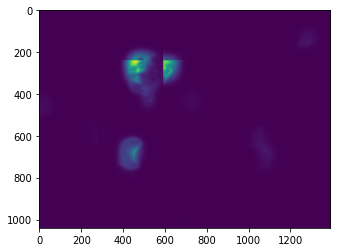

In [ ]:
plt.imshow(softmax)

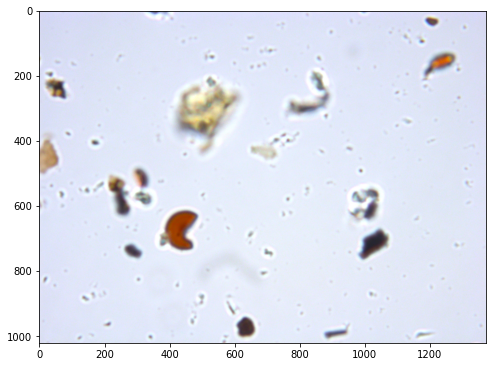

In [ ]:
slice_path=[]
current_image_path= os.path.join(path_to_image, current_example[0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.bmp'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
img = mpimg.imread(slice_path[4]).copy()

plt.figure(figsize=(8,8)) # figsize -- inch-by-inch
plt.imshow(img)

In [ ]:
gt_dir = os.path.join(eval_dir, 'gt')
if not os.path.exists(gt_dir): 
    os.makedirs(gt_dir)
print(gt_dir)

/content/gdrive/MyDrive/eval/02_Exp1_SmallGrains/Trial_04/gt


In [ ]:
iterCount, sampleCount = 0, 0

for sample in dataloaders:   
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
    GTSegMask = curmask_OrgSize >0.5
    GTSegMask = measure.label(GTSegMask, background=0)

    props = measure.regionprops(np.squeeze(GTSegMask)) #get the properties of the connected components
    bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components
    gt_filename = os.path.join(gt_dir, current_example[0] + '.txt')
    # i=2
    gt_info = []
    for i in range(len(props)): 
      class_name="det"
      left = bbox[i][1]
      top = bbox[i][0]
      right = bbox[i][3]
      bottom = bbox[i][2]
      # predDistTransformCrop = predDistTransform[top:bottom, left:right]
      # confidence = np.amax(predDistTransformCrop)
      bbox_info = [class_name, str(left), str(top), str(right), str(bottom)]
      bbox_info = ' '.join(bbox_info)

      gt_info.append(bbox_info)

    fn = open(gt_filename,'w')
    for i in gt_info:
      fn.write(i + "\n")
    fn.close()